# Project: No-show appointments dataset analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. This data set contain records whether patients miss appointments ot not, information about appointments and attributes of patients.<br>
In this project I am trying to determine if some variables influence the probability of whether or not patient is going to show up to the appointment and what is the correlation between the variables in the dataset.

### Questions:<br>
>(1) Is gender a significant contributor of whether or not patients show up for their appointment?<br>
>(2) Is place of living a significant contributor of whether or not patients show up for their appointment?<br>
>(3) Is age a significant contributor of whether or not patients show up for their appointment?<br>
>(4) What are the correlations between the variables is the dataset

<a id='wrangling'></a>
## Data Wrangling

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [266]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

### columns clean-up

In [267]:
df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

lets delete columns that do not have any impact on whether patient will show up or not (they are probably just a set of random numbers assinged to particular patient/appointment)

In [268]:
df.drop(['patientid','appointmentid'],axis=1,inplace=True)

### missing/duplicated values

In [ ]:
df.isnull().sum().sum()

above line of code returns zero which means that there are no NaN values in the dataset

In [270]:
df.drop_duplicates(inplace=True)

### fixing data types

In [271]:
df.dtypes

gender            object
scheduledday      object
appointmentday    object
age                int64
neighbourhood     object
scholarship        int64
hipertension       int64
diabetes           int64
alcoholism         int64
handcap            int64
sms_received       int64
no-show           object
dtype: object

All columns seem to be fine except for 'scheduledday' and 'appointmentday', lets convert dates to datetime data type

In [272]:
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

### validation data

In [273]:
df.nunique()

gender                 2
scheduledday      103549
appointmentday        27
age                  104
neighbourhood         81
scholarship            2
hipertension           2
diabetes               2
alcoholism             2
handcap                5
sms_received           2
no-show                2
dtype: int64

Based on above output 'handcap' feature seems suspicious as per the data descirption this should be a binary variable

- 'handcap' column clean-up

In [274]:
df['handcap'].value_counts()

0    107673
1      2023
2       182
3        11
4         3
Name: handcap, dtype: int64

As we can find above we have approximately 200 values above '1', I decided to remove all of them as this is a binary variable

In [275]:
df = df[df.handcap < 2]

- 'age' column clean-up

In [276]:
df['age'].describe()

count    109696.000000
mean         37.071488
std          23.109296
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

As we can find above minimum age is below zero, age equals '-1' is a mistake, lets remove this entry from the dataset

In [277]:
df = df[df.age >= 0]

<a id='eda'></a>
## Exploratory Data Analysis

### (1) Is gender a significant contributor of whether or not patients show up for their appointment?

In [278]:
df_male = df[df['gender'] == 'M']

In [279]:
df_female = df[df['gender'] == 'F']

- ratio of males that do not show up for their appointment

In [280]:
male_absence = df_male.groupby(['no-show'])['gender'].count()['Yes'] / df_male.shape[0]

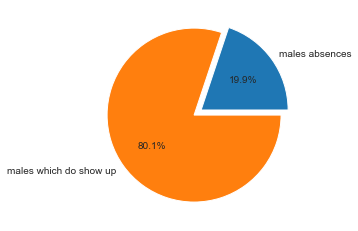

In [281]:
plt.pie([male_absence,1-male_absence], labels = ['males absences','males which do show up'], explode = [0.1,0], autopct='%1.1f%%');

- ratio of females that do not show up for their appointment

In [282]:
female_absence = df_female.groupby(['no-show'])['gender'].count()['Yes'] / df_female.shape[0]

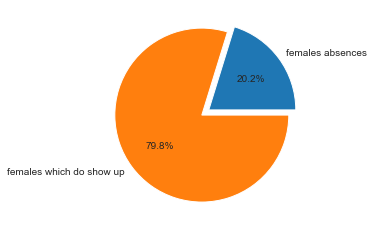

In [283]:
plt.pie([female_absence,1-female_absence], labels = ['females absences','females which do show up'], explode = [0.1,0], autopct='%1.1f%%');

### (2) Is place of living a significant contributor of whether or not patients show up for their appointment?

- Number of appointments in each region

In [284]:
neighbourhood_series = df.groupby(['neighbourhood'])['no-show'].count()
neighbourhood_dataframe = pd.DataFrame(neighbourhood_series)
neighbourhood_dataframe.rename(columns={'no-show':'number_of_appointments'},inplace=True)

I will take into consideration only the regions with more than 100 samples

In [285]:
neighbourhood_dataframe = neighbourhood_dataframe[neighbourhood_dataframe['number_of_appointments'] > 100]

- Number of absences in each region

In [286]:
dataframe_with_no_shows = df[df['no-show']=='Yes']
neighbourhood_absence_series = dataframe_with_no_shows.groupby(['neighbourhood'])['no-show'].count()
neighbourhood_absence_dataframe = pd.DataFrame(neighbourhood_absence_series)
neighbourhood_absence_dataframe.rename(columns={'no-show':'number_of_absences'},inplace=True)

- dataframe with both number of appointments and absences

In [287]:
df_combined = neighbourhood_dataframe.merge(neighbourhood_absence_dataframe, left_on='neighbourhood', right_on='neighbourhood', how='left')

- ratio of absences in each region

In [288]:
df_combined['absence_ratio'] = df_combined['number_of_absences'] / df_combined['number_of_appointments'] * 100
df_combined.sort_values(['absence_ratio'],ascending=False,inplace=True)

In [289]:
import seaborn as sns
sns.set_style('darkgrid')

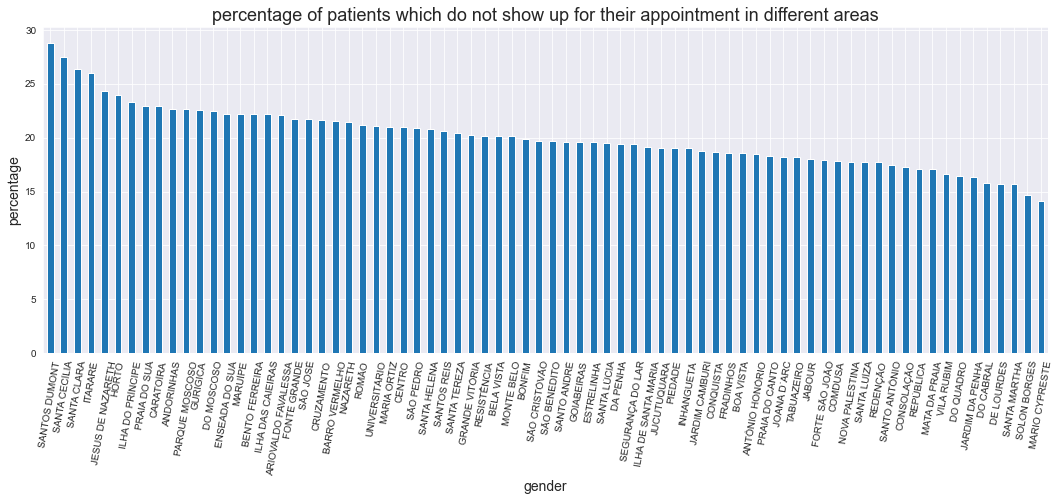

In [290]:
df_combined.plot.bar(y = 'absence_ratio', figsize=(18,6), legend = False, rot=80)
plt.xlabel('gender', fontsize = 14)
plt.ylabel('percentage', fontsize = 14)
plt.title('percentage of patients which do not show up for their appointment in different areas', fontsize = 18);

As we can find in above bar chart percentage of patients which do not show up for their appointment depends to some extent on where the appointments take place

### (3) Is age a significant contributor of whether or not patients show up for their appointment?

- number of appointments for each age group (0-10, 10-20, etc.)

In [291]:
bin_edges = [-1,10,20,30,40,50,60,70,80,90,100,110,120]
bin_names = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110','110-120']
df['age_bin'] = pd.cut(df['age'], bin_edges, labels=bin_names)
age_bin_series = df.groupby(['age_bin'])['age_bin'].count()
age_bin_dataframe = pd.DataFrame(age_bin_series)
age_bin_dataframe.rename(columns={'age_bin':'number_of_appointments'},inplace=True)
age_bin_dataframe

,number_of_appointments
age_bin,
0-10,18658
10-20,12971
20-30,13682
30-40,14913
40-50,14322
50-60,15541
60-70,11123
70-80,5690
80-90,2494


as we can find in above dataframe samples with age between 100-110 and 110-120 are too small to take them into consideration so lets remove them

In [292]:
age_bin_dataframe = age_bin_dataframe[age_bin_dataframe['number_of_appointments'] > 100]

- number of absences in each age group

In [293]:
dataframe_with_no_shows = df[df['no-show']=='Yes']
age_bin_absences_series = dataframe_with_no_shows.groupby(['age_bin'])['no-show'].count()
age_bin_absences_dataframe = pd.DataFrame(age_bin_absences_series)
age_bin_absences_dataframe.rename(columns={'no-show':'number_of_absences'},inplace=True)

- dataframe with both number of appointments and absences

In [294]:
df_combined = age_bin_dataframe.merge(age_bin_absences_dataframe, left_on='age_bin', right_on='age_bin', how='left')

- ratio of absences in each region

In [295]:
df_combined['absence_ratio'] = df_combined['number_of_absences'] / df_combined['number_of_appointments'] * 100

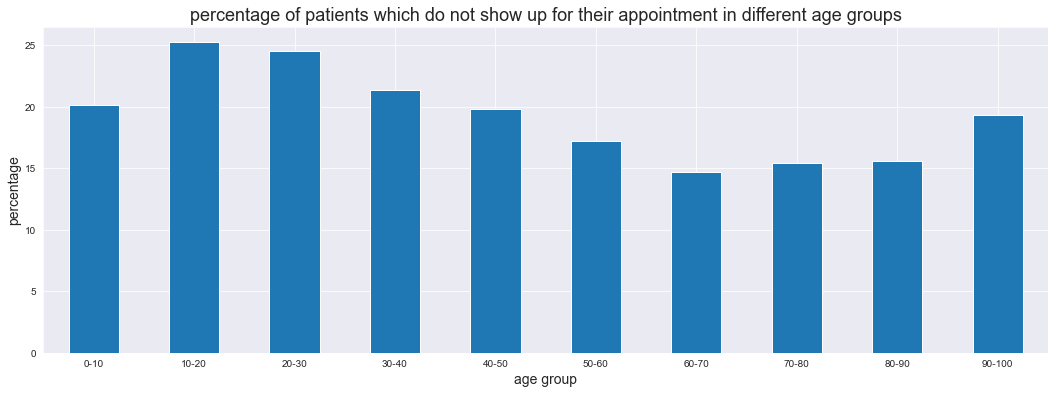

In [296]:
df_combined.plot.bar(y = 'absence_ratio', figsize=(18,6), legend = False, rot=0)
plt.xlabel('age group', fontsize = 14)
plt.ylabel('percentage', fontsize = 14)
plt.title('percentage of patients which do not show up for their appointment in different age groups', fontsize = 18);

Percentage of patients which do not show up for their appointment differs in younger and older age groups

### (4) What are the correlations between numeric values is the dataset?

In [297]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received
age,1.00,-0.09,0.50,0.29,0.10,0.08,0.01
scholarship,-0.09,1.00,-0.02,-0.02,0.03,-0.01,0.00
hipertension,0.50,-0.02,1.00,0.43,0.09,0.08,-0.01
diabetes,0.29,-0.02,0.43,1.00,0.02,0.05,-0.01
alcoholism,0.10,0.03,0.09,0.02,1.00,0.00,-0.03
handcap,0.08,-0.01,0.08,0.05,0.00,1.00,-0.02
sms_received,0.01,0.00,-0.01,-0.01,-0.03,-0.02,1.00


As we can find in above correlation matrix most of variables in the dataset are not correlated except for hipertension and diabetes are correlated with age and diabetes is correlated with hipertension

<a id='conclusions'></a>
## Conclusions

### Conclusions:
> **#1**: Similar ratio of both males and females do not show up for their appointment

> **#2**: There is a significant difference in regards to the absence ratio in the particular areas. The greatest ratio of absences is in the 'Santos Dumont' (~ 29%) while the lowest is in the 'Mario Cypreste' area (~ 14%)

> **#3**: Older people more often show up for their appointment

> **#4**: Hipertension and diabetes seems to be correlated with age. Also diabetes is correlated with hipertension

### Limitations
> **#1**: Most of variables are categorical binary which does not allow to show strong correlation between them

> **#2**: The statistics used here are descriptive statistics meaning that I did not create any hypotheses to verify